 # <center> Twitter sentiment Analysis

## Part 1 : practical example using SentiWordnet

#**Importing Required Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import re

In [3]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
#nltk.download('wordnet')
#nltk.download('sentiwordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#**Text PreProcessing**

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
sentence = "One of the best movie of all time. Period."

#### (1) Removing Punctuations

In [9]:
#punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
punctuations = list(string.punctuation)

for x in sentence: 
  if x in punctuations: 
    sentence = sentence.replace(x, "")

print(sentence)

One of the best movie of all time Period


In [10]:
# OR
sentence = re.sub('[%s]' % re.escape(string.punctuation), '' , sentence)
print(sentence)

One of the best movie of all time Period


#### (2) Change Case + Tokenization

In [11]:
Tokens = nltk.word_tokenize(sentence.lower())
print(Tokens)

['one', 'of', 'the', 'best', 'movie', 'of', 'all', 'time', 'period']


#### (3) Removing Stop Words - a, an, the, are, is etc.

In [12]:
stop_words = set(stopwords.words('english'))
clean_Tokens = [word for word in Tokens if word not in stop_words]
print(clean_Tokens)

['one', 'best', 'movie', 'time', 'period']


#### (4) Lemmatization

In [13]:
lemma = [lemmatizer.lemmatize(word) for word in clean_Tokens]

print(lemma)

['one', 'best', 'movie', 'time', 'period']


#### (5) POS Tagging

A part-of-speech tagger, or POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word (don't forget to import nltk)

In [14]:
lemma

['one', 'best', 'movie', 'time', 'period']

In [15]:
pos_val = nltk.pos_tag(lemma)
print(pos_val)

[('one', 'CD'), ('best', 'JJS'), ('movie', 'NN'), ('time', 'NN'), ('period', 'NN')]


CC, a coordinating conjunction;

RB, or adverbs;  

IN, a preposition; 

NN, a noun; 

JJ, an adjective.

The most popular tag set is Penn Treebank tagset. Most of the already trained taggers for English are trained on this tag set. To view the complete list, follow this link--> https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html.

In [16]:
pos, neg, obj, count = 0,0,0,0

In [17]:
# We can get more details about any POS tag using help funciton of NLTK as follows.
#nltk.download('tagsets')
#nltk.download('universal_tagset')
#nltk.help.upenn_tagset("JJS$")

In [18]:
#nltk.download('universal_tagset')
pos_val2 = nltk.pos_tag(lemma, tagset='universal')
print(pos_val2)

[('one', 'NUM'), ('best', 'ADJ'), ('movie', 'NOUN'), ('time', 'NOUN'), ('period', 'NOUN')]


#**Functions for Sentiment Scoring**

In [19]:
# Convert between the PennTreebank tags to simple Wordnet tags
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('C'):
        return wn.NOUN
    return None

you can find the whol peeTreebank here https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [20]:
# Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
# Synset instances are the groupings of synonymous words that express the same concept. 
# Some of the words have only one Synset and some have several.

# Returns list of pos-neg and objective score. But returns empty list if not present in SentiWordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
        return []
    
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [21]:
get_sentiment('one', 'CD')

['one.n.01', 0.0, 0.0, 1.0]

In [22]:
senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
print(senti_val)

[['one.n.01', 0.0, 0.0, 1.0], ['best.a.01', 0.75, 0.0, 0.25], ['movie.n.01', 0.0, 0.0, 1.0], ['time.n.01', 0.0, 0.0, 1.0], ['time_period.n.01', 0.125, 0.125, 0.75]]


#**Aggregating Scores**

In [23]:
for i in range(len(senti_val)):
  try:
    pos = pos + senti_val[i][1]
    neg = neg + senti_val[i][2]
    obj = obj + senti_val[i][3]
  
  except:
    continue

In [24]:
print("Positive weight : {0} ".format(pos))
print("Negative weight : {0} ".format(neg))
print("Sentiment of the statement is {0} ".format(pos - neg))

Positive weight : 0.875 
Negative weight : 0.125 
Sentiment of the statement is 0.75 


## Part 2 : twitter sentiment Analysis

In [25]:
#data
#!pip install openpyxl

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
Tweet = pd.read_excel("US_Airline_Tweets.xlsx")

In [28]:
Tweet

,Tweets,Manually_Annotated
0,@VirginAmerica What @dhepburn said.,Neutral
1,@VirginAmerica plus you've added commercials t...,Positive
2,@VirginAmerica I didn't today... Must mean I n...,Neutral
3,@VirginAmerica it's really aggressive to blast...,Negative
4,@VirginAmerica and it's a really big bad thing...,Negative
...,...,...
995,@united #UnitedAirlines Pls Fix #AspenBaggageF...,Negative
996,@united Read my bio. See who I work with. I ha...,Negative
997,@united Does customer care have email or a pho...,Negative
998,Thank you â€œ@united: @TRUU_Tall I can certain...,Positive


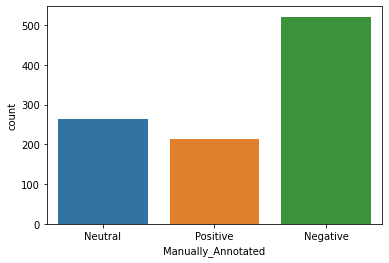

In [29]:
# Classes count
sns.countplot(Tweet.Manually_Annotated)
plt.show()

**N.B : the Dataset is not balanced**

In [30]:
data = Tweet['Tweets']
data

0                    @VirginAmerica What @dhepburn said.
1      @VirginAmerica plus you've added commercials t...
2      @VirginAmerica I didn't today... Must mean I n...
3      @VirginAmerica it's really aggressive to blast...
4      @VirginAmerica and it's a really big bad thing...
                             ...                        
995    @united #UnitedAirlines Pls Fix #AspenBaggageF...
996    @united Read my bio. See who I work with. I ha...
997    @united Does customer care have email or a pho...
998    Thank you â€œ@united: @TRUU_Tall I can certain...
999    @united In the process of recovering their car...
Name: Tweets, Length: 1000, dtype: object

In [31]:
#preprocessing
def tweet_preprocess(raw_tweet):
    
    raw_tweet = re.sub("@\w+","",raw_tweet).strip()
    raw_tweet = re.sub("http\S+","",raw_tweet).strip()
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    lemma = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    return lemma

In [32]:
new_data = data.apply(tweet_preprocess)
new_data

0                                                 [said]
1           [plus, added, commercial, experience, tacky]
2         [today, must, mean, need, take, another, trip]
3      [really, aggressive, blast, obnoxious, enterta...
4                              [really, big, bad, thing]
                             ...                        
995    [unitedairlines, pls, fix, aspenbaggagefail, i...
996    [read, bio, see, work, never, encountered, air...
997    [customer, care, email, phone, rep, speak, man...
998    [thank, certainly, take, look, please, follow,...
999    [process, recovering, car, rental, condo, rent...
Name: Tweets, Length: 1000, dtype: object

### for each tweet get it sentiment using SentiWordnet

In [33]:
pos_val_tweet = new_data.apply(nltk.pos_tag)
pos_val_tweet

0                                          [(said, VBD)]
1      [(plus, CC), (added, JJ), (commercial, JJ), (e...
2      [(today, NN), (must, MD), (mean, VB), (need, M...
3      [(really, RB), (aggressive, JJ), (blast, NN), ...
4      [(really, RB), (big, JJ), (bad, JJ), (thing, NN)]
                             ...                        
995    [(unitedairlines, NNS), (pls, VBP), (fix, JJ),...
996    [(read, JJ), (bio, NN), (see, VBP), (work, NN)...
997    [(customer, NN), (care, NN), (email, NN), (pho...
998    [(thank, NN), (certainly, RB), (take, VBP), (l...
999    [(process, NN), (recovering, VBG), (car, NN), ...
Name: Tweets, Length: 1000, dtype: object

In [34]:
senti_val_tweet = []
for i in range(len(pos_val_tweet)):
    sent = [get_sentiment(x,y) for (x,y) in pos_val_tweet[i]]
    senti_val_tweet.append(sent)

In [35]:
senti_val_tweet[:3]

[[['state.v.01', 0.0, 0.0, 1.0]],
 [['asset.n.01', 0.625, 0.0, 0.375],
  [],
  ['commercial.a.01', 0.0, 0.0, 1.0],
  ['experience.n.01', 0.0, 0.0, 1.0],
  []],
 [['today.n.01', 0.125, 0.0, 0.875],
  [],
  ['mean.v.01', 0.0, 0.0, 1.0],
  [],
  ['take.v.01', 0.0, 0.0, 1.0],
  [],
  ['trip.n.01', 0.0, 0.0, 1.0]]]

#**Aggregating Scores**

In [36]:
tweet_scores = []
for i in range(len(senti_val_tweet)):
    pos = 0
    neg = 0
    obj = 0
    for j in range(len(senti_val_tweet[i])):
        try:
            pos = pos + senti_val_tweet[i][j][1]
            neg = neg + senti_val_tweet[i][j][2]
            obj = obj + senti_val_tweet[i][j][3]
        except:
            continue
    tweet_scores.append((pos,neg,obj))

In [37]:
# First 10 tweets scores
tweet_scores[:10]

[(0.0, 0.0, 1.0),
 (0.625, 0.0, 2.375),
 (0.125, 0.0, 3.875),
 (1.125, 1.125, 6.75),
 (0.875, 0.75, 2.375),
 (0.875, 0.625, 8.5),
 (0.0, 0.0, 7.0),
 (1.5, 0.875, 3.625),
 (0.375, 0.0, 0.625),
 (0.75, 0.25, 4.0)]

In [38]:
df = zip(data,tweet_scores)

In [39]:
df = pd.DataFrame(df, columns=['Tweets', 'Scores'])
df

,Tweets,Scores
0,@VirginAmerica What @dhepburn said.,"(0.0, 0.0, 1.0)"
1,@VirginAmerica plus you've added commercials t...,"(0.625, 0.0, 2.375)"
2,@VirginAmerica I didn't today... Must mean I n...,"(0.125, 0.0, 3.875)"
3,@VirginAmerica it's really aggressive to blast...,"(1.125, 1.125, 6.75)"
4,@VirginAmerica and it's a really big bad thing...,"(0.875, 0.75, 2.375)"
...,...,...
995,@united #UnitedAirlines Pls Fix #AspenBaggageF...,"(0.125, 0.875, 9.0)"
996,@united Read my bio. See who I work with. I ha...,"(0.0, 0.875, 5.125)"
997,@united Does customer care have email or a pho...,"(0.125, 0.0, 7.875)"
998,Thank you â€œ@united: @TRUU_Tall I can certain...,"(1.125, 1.0, 5.875)"


In [40]:
df['pos'] = df['Scores'].apply(lambda x:x[0])
df['neg'] = df['Scores'].apply(lambda x:x[1])
df['obj'] = df['Scores'].apply(lambda x:x[2])

In [41]:
df.drop(columns = ['Scores'],inplace = True)

In [42]:
df

,Tweets,pos,neg,obj
0,@VirginAmerica What @dhepburn said.,0.000,0.000,1.000
1,@VirginAmerica plus you've added commercials t...,0.625,0.000,2.375
2,@VirginAmerica I didn't today... Must mean I n...,0.125,0.000,3.875
3,@VirginAmerica it's really aggressive to blast...,1.125,1.125,6.750
4,@VirginAmerica and it's a really big bad thing...,0.875,0.750,2.375
...,...,...,...,...
995,@united #UnitedAirlines Pls Fix #AspenBaggageF...,0.125,0.875,9.000
996,@united Read my bio. See who I work with. I ha...,0.000,0.875,5.125
997,@united Does customer care have email or a pho...,0.125,0.000,7.875
998,Thank you â€œ@united: @TRUU_Tall I can certain...,1.125,1.000,5.875


#**Predicting sentiments**

### 1 - Traditional method :

In [43]:
df2 = df.copy()

In [44]:
for i in range(len(df2)) :
    
    sentiment_score = df2.loc[i,'pos'] - df2.loc[i,'neg']
    treshold = 0
    
    if sentiment_score > treshold:
        df2.loc[i,'Predicted_Sentiment'] = 'Positive'
        
    else:
        df2.loc[i,'Predicted_Sentiment'] = 'Negative'
        
    if df2.loc[i,'pos']==0 and df2.loc[i,'neg']==0:
        df2.loc[i,'Predicted_Sentiment'] = 'Neutral'

In [45]:
df2

,Tweets,pos,neg,obj,Predicted_Sentiment
0,@VirginAmerica What @dhepburn said.,0.000,0.000,1.000,Neutral
1,@VirginAmerica plus you've added commercials t...,0.625,0.000,2.375,Positive
2,@VirginAmerica I didn't today... Must mean I n...,0.125,0.000,3.875,Positive
3,@VirginAmerica it's really aggressive to blast...,1.125,1.125,6.750,Negative
4,@VirginAmerica and it's a really big bad thing...,0.875,0.750,2.375,Positive
...,...,...,...,...,...
995,@united #UnitedAirlines Pls Fix #AspenBaggageF...,0.125,0.875,9.000,Negative
996,@united Read my bio. See who I work with. I ha...,0.000,0.875,5.125,Negative
997,@united Does customer care have email or a pho...,0.125,0.000,7.875,Positive
998,Thank you â€œ@united: @TRUU_Tall I can certain...,1.125,1.000,5.875,Positive


In [46]:
# Scoring
y_true = Tweet['Manually_Annotated']
y_pred = df2['Predicted_Sentiment']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    Negative       0.73      0.49      0.59       521
     Neutral       0.44      0.28      0.34       265
    Positive       0.29      0.66      0.41       214

    accuracy                           0.47      1000
   macro avg       0.49      0.48      0.45      1000
weighted avg       0.56      0.47      0.48      1000



### 2 - Machine Learning :

In [47]:
# evaluate a model :
def eval(model,X,y):
    y_pred = model.predict(X)
    
    cr = classification_report(y_test,model.predict(X_test), target_names=['Negative','Neutral','Positive'],output_dict=True)
    macro_avg = pd.DataFrame(cr).T['f1-score'].iloc[4]
    acc = pd.DataFrame(cr).T['f1-score'].iloc[3]
    
    print(str(model))
    print('-'*60)
    print(classification_report(y, y_pred,target_names=['Negative','Neutral','Positive']))
    
    return [macro_avg, acc]

In [48]:
mapper = {'Negative':0, 'Neutral':1, 'Positive':2}

In [49]:
X = df[['pos','neg','obj']]
y = Tweet['Manually_Annotated'].map(mapper)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=30)

In [51]:
print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (800, 3)
y_train shape : (800,)
X_test shape : (200, 3)
y_test shape : (200,)


In [52]:
results = {}

### Random Forest

In [53]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [54]:
# On train set
eval(rfc, X_train, y_train)

RandomForestClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87       417
     Neutral       0.66      0.76      0.71       210
    Positive       0.74      0.60      0.66       173

    accuracy                           0.79       800
   macro avg       0.76      0.74      0.75       800
weighted avg       0.79      0.79      0.78       800



[0.4576489533011272, 0.515]

In [55]:
# On test set
results['RandomForest'] = eval(rfc, X_test, y_test)

RandomForestClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.66      0.65      0.66       104
     Neutral       0.37      0.40      0.38        55
    Positive       0.35      0.32      0.33        41

    accuracy                           0.52       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.52      0.52      0.52       200



### Decision Tree

In [56]:
dtc = DecisionTreeClassifier(min_samples_split = 10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=10)

In [57]:
# On train set
eval(dtc, X_train, y_train)

DecisionTreeClassifier(min_samples_split=10)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.77      0.86      0.81       417
     Neutral       0.61      0.69      0.65       210
    Positive       0.68      0.39      0.49       173

    accuracy                           0.71       800
   macro avg       0.69      0.65      0.65       800
weighted avg       0.71      0.71      0.70       800



[0.44392498783550977, 0.505]

In [58]:
# On test set
results['DecisionTree'] = eval(dtc, X_test, y_test)

DecisionTreeClassifier(min_samples_split=10)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.62      0.65      0.64       104
     Neutral       0.34      0.40      0.37        55
    Positive       0.41      0.27      0.32        41

    accuracy                           0.51       200
   macro avg       0.46      0.44      0.44       200
weighted avg       0.50      0.51      0.50       200



### Logistic Regression :

In [59]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [60]:
# On train set
eval(lr, X_train, y_train)

LogisticRegression()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.66      0.85      0.75       417
     Neutral       0.47      0.41      0.44       210
    Positive       0.44      0.21      0.28       173

    accuracy                           0.60       800
   macro avg       0.53      0.49      0.49       800
weighted avg       0.57      0.60      0.57       800



[0.4891594516594517, 0.585]

In [61]:
# On test set
results['LogisticRegression'] = eval(lr, X_test, y_test)

LogisticRegression()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.67      0.82      0.74       104
     Neutral       0.44      0.40      0.42        55
    Positive       0.43      0.24      0.31        41

    accuracy                           0.58       200
   macro avg       0.51      0.49      0.49       200
weighted avg       0.56      0.58      0.56       200



### KNN

In [62]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [63]:
# On train set
eval(knn, X_train, y_train)

KNeighborsClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.69      0.90      0.78       417
     Neutral       0.60      0.44      0.51       210
    Positive       0.58      0.35      0.44       173

    accuracy                           0.66       800
   macro avg       0.62      0.56      0.58       800
weighted avg       0.64      0.66      0.64       800



[0.4470033795691568, 0.535]

In [64]:
# On test set
results['KNN'] = eval(knn, X_test, y_test)

KNeighborsClassifier()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.61      0.76      0.68       104
     Neutral       0.46      0.31      0.37        55
    Positive       0.32      0.27      0.29        41

    accuracy                           0.54       200
   macro avg       0.47      0.45      0.45       200
weighted avg       0.51      0.54      0.51       200



### Linear SVM :

In [65]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_sc = std.fit_transform(X_train)
X_test_sc = std.transform(X_test)

In [66]:
lsvm = LinearSVC()
lsvm.fit(X_train_sc, y_train)

LinearSVC()

In [67]:
# On train set
eval(lsvm, X_train_sc, y_train)

LinearSVC()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.66      0.86      0.75       417
     Neutral       0.47      0.41      0.44       210
    Positive       0.49      0.19      0.27       173

    accuracy                           0.60       800
   macro avg       0.54      0.49      0.49       800
weighted avg       0.57      0.60      0.56       800



[0.2280701754385965, 0.52]

In [68]:
# On test set
results['LinearSVM'] = eval(lsvm, X_test_sc, y_test)

LinearSVC()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.68      0.87      0.76       104
     Neutral       0.45      0.40      0.42        55
    Positive       0.50      0.22      0.31        41

    accuracy                           0.60       200
   macro avg       0.54      0.49      0.50       200
weighted avg       0.58      0.60      0.57       200



### Gaussian Naive Bayes

In [69]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [70]:
# On train set
eval(gnb, X_train, y_train)

GaussianNB()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.72      0.75      0.73       417
     Neutral       0.41      0.60      0.49       210
    Positive       0.44      0.16      0.23       173

    accuracy                           0.58       800
   macro avg       0.52      0.50      0.48       800
weighted avg       0.58      0.58      0.56       800



[0.50843776106934, 0.595]

In [71]:
# On test set
results['GaussianNB'] = eval(gnb, X_test, y_test)

GaussianNB()
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.73      0.74      0.73       104
     Neutral       0.44      0.62      0.51        55
    Positive       0.50      0.20      0.28        41

    accuracy                           0.59       200
   macro avg       0.55      0.52      0.51       200
weighted avg       0.60      0.59      0.58       200



### Artificial Neural Network :

In [72]:
import tensorflow as tf
from tensorflow import keras

#### Construct the model :

In [73]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[3]))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 100)               400       
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 5,603
Trainable params: 5,603
Non-trainable params: 0
_________________________________________________________________


#### Compile the model :

In [75]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=['accuracy'])

#### Train the model :

In [76]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
25/25 [==============================] - 1s 9ms/step - loss: 0.9917 - accuracy: 0.4950 - val_loss: 0.9648 - val_accuracy: 0.5150
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.9571 - accuracy: 0.5250 - val_loss: 0.9609 - val_accuracy: 0.5250
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.9519 - accuracy: 0.5288 - val_loss: 0.9606 - val_accuracy: 0.5250
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.9494 - accuracy: 0.5288 - val_loss: 0.9605 - val_accuracy: 0.5250
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.9484 - accuracy: 0.5288 - val_loss: 0.9565 - val_accuracy: 0.5250
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.9445 - accuracy: 0.5325 - val_loss: 0.9537 - val_accuracy: 0.5350
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 0.9420 - accuracy: 0.5350 - val_loss: 0.9526 - val_accuracy: 0.5350
Epoch 8/20
25/25 [==

#### Plot learning Curves :

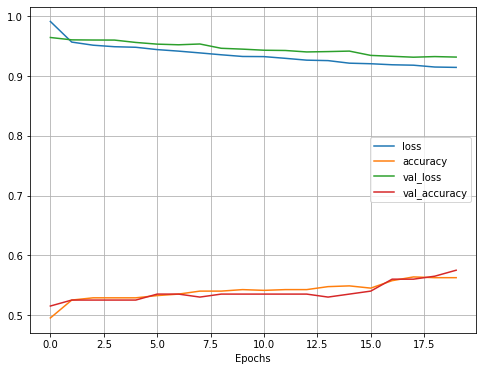

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True)
plt.xlabel('Epochs')
plt.show()

#### Evaluate the model :

In [78]:
pred = model.predict(X_test)
y_pred = []
for i in range(len(pred)):
    y_pred.append(np.argmax(pred[i]))

7/7 [==============================] - 0s 2ms/step


In [79]:
cr = classification_report(y_test,y_pred, target_names=['Negative','Neutral','Positive'],output_dict=True)
macro_avg = pd.DataFrame(cr).T['f1-score'].iloc[4]
acc = pd.DataFrame(cr).T['f1-score'].iloc[3]
results['ANN'] = [macro_avg,acc]

In [80]:
# On test set
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.59      0.95      0.73       104
     Neutral       0.43      0.24      0.31        55
    Positive       1.00      0.07      0.14        41

    accuracy                           0.57       200
   macro avg       0.68      0.42      0.39       200
weighted avg       0.63      0.57      0.49       200



## Conclusion :

In [81]:
scores = pd.DataFrame(results, index = ['macro_avg_f1', 'accuracy']).T

In [82]:
# Models sorted by accuracy on test set :
scores.sort_values('accuracy',ascending=False)

,macro_avg_f1,accuracy
GaussianNB,0.508438,0.595
LogisticRegression,0.489159,0.585
ANN,0.390958,0.575
KNN,0.447003,0.535
LinearSVM,0.228070,0.520
RandomForest,0.457649,0.515
DecisionTree,0.443925,0.505


In [83]:
# Models sorted by macro_avg_f1_score on test set :
scores.sort_values('macro_avg_f1',ascending=False)

,macro_avg_f1,accuracy
GaussianNB,0.508438,0.595
LogisticRegression,0.489159,0.585
RandomForest,0.457649,0.515
KNN,0.447003,0.535
DecisionTree,0.443925,0.505
ANN,0.390958,0.575
LinearSVM,0.228070,0.520


**Gaussian Naive Bayes is the best model for Sentiment Analysis**

Even if tweets are manually annotated and the dataset is not balanced, our classifiers did a great job to detect tweets sentiments, and by fine-tuning the models and getting more data, we can achieve better results.